<a href="https://colab.research.google.com/github/tikendraw/caption-generator/blob/main/transformer_in_making.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
import os, sys

if 'google.colab' in sys.modules:
    !git clone https://github.com/tikendraw/caption-generator.git
    !git clone https://github.com/tikendraw/funcyou.git
    !pip install funcyou/.
    os.chdir('caption-generator')
    print(os.getcwd())

<IPython.core.display.Javascript object>

In [3]:
import os, sys
import numpy as np
import pandas as pd
import random, math
import tensorflow as tf
import glob
import shutil
from zipfile import ZipFile
import datetime
import sys
from functools import cache
from pathlib import Path
from tqdm import tqdm
import regex as re

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from sklearn.model_selection import train_test_split


from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocessing
from tensorflow.keras.layers import (
    TextVectorization, Embedding, LSTM, GRU, Bidirectional, TimeDistributed, Dense, Attention, MultiHeadAttention, Flatten, Dropout,
    Concatenate, Activation, GlobalAveragePooling2D
    )
from tensorflow.keras.layers import LSTM, Embedding, Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow import keras
from tensorflow.keras.utils import array_to_img, img_to_array
import string
from preprocessing import preprocess_text, mapper, clean_words
from utils import create_model_checkpoint

from config import config

from get_data import download_dataset
from funcyou.dataset import download_kaggle_dataset

2023-05-24 19:58:44.890541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 19:58:45.678501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-24 19:58:47.053413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-24 19:58:47.078386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

<IPython.core.display.Javascript object>

In [4]:
BATCH_SIZE =    config.BATCH_SIZE
IMG_SIZE =      config.IMG_SIZE
CHANNELS =      config.CHANNELS
IMG_SHAPE =     config.IMG_SHAPE
MAX_LEN =       config.MAX_LEN
EPOCHS =        config.EPOCHS
LEARNING_RATE = config.LEARNING_RATE
UNITS =         config.UNITS
raw_caption_file =  config.raw_caption_file
caption_file =  config.caption_file
image_dir =     config.image_dir
glove_path =    config.glove_path
TEST_SIZE =     config.TEST_SIZE
VAL_SIZE=       config.VAL_SIZE
EMBEDDING_DIMENSION =   config.EMBEDDING_DIMENSION 

<IPython.core.display.Javascript object>

In [5]:
print(f'''{BATCH_SIZE=}
{IMG_SIZE=}
{CHANNELS=}
{IMG_SHAPE=}
{MAX_LEN=}
{EPOCHS=}
{LEARNING_RATE=}
{UNITS=}
{raw_caption_file=}
{caption_file=}
{image_dir=}

{glove_path=}
{TEST_SIZE=}
{VAL_SIZE=}
{EMBEDDING_DIMENSION=}''')

BATCH_SIZE=8
IMG_SIZE=256
CHANNELS=3
IMG_SHAPE=(256, 256, 3)
MAX_LEN=50
EPOCHS=10
LEARNING_RATE=0.01
UNITS=16
raw_caption_file=PosixPath('input/flickr30k/results.csv')
caption_file=PosixPath('input/flickr30k/results_cleaned.csv')
image_dir=PosixPath('input/flickr30k/images')

glove_path=PosixPath('embedding/glove.6B.50d.zip')
TEST_SIZE=0.05
VAL_SIZE=0.05
EMBEDDING_DIMENSION=50


<IPython.core.display.Javascript object>

In [6]:
batch_size = 8
image_size = 256  # We'll resize input images to this size
patch_size = 42  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2 # trich here is to match max_len to num_patches for matching the shapes for concatination
max_len = 36

assert max_len == num_patches

d_model = 128


num_heads = 4
transformer_units = [
    d_model * 2,
    d_model,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

<IPython.core.display.Javascript object>

![image](https://github.com/tikendraw/caption-generator/blob/main/'./transformer.png'?raw=1)

# Positional Encoding for text

In [7]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

<IPython.core.display.Javascript object>

In [8]:
a = positional_encoding(10, 4)
a.shape, a

(TensorShape([10, 4]),
 <tf.Tensor: shape=(10, 4), dtype=float32, numpy=
 array([[ 0.        ,  0.        ,  1.        ,  1.        ],
        [ 0.84147096,  0.00999983,  0.5403023 ,  0.99995   ],
        [ 0.9092974 ,  0.01999867, -0.41614684,  0.9998    ],
        [ 0.14112   ,  0.0299955 , -0.9899925 ,  0.99955004],
        [-0.7568025 ,  0.03998933, -0.6536436 ,  0.9992001 ],
        [-0.9589243 ,  0.04997917,  0.2836622 ,  0.99875027],
        [-0.2794155 ,  0.059964  ,  0.96017027,  0.99820054],
        [ 0.6569866 ,  0.06994285,  0.75390226,  0.997551  ],
        [ 0.98935825,  0.0799147 , -0.14550003,  0.99680173],
        [ 0.4121185 ,  0.08987855, -0.91113025,  0.9959527 ]],
       dtype=float32)>)

<IPython.core.display.Javascript object>

In [9]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

<IPython.core.display.Javascript object>

In [10]:
sent = tf.random.uniform((1,MAX_LEN), maxval=30, dtype=tf.int32)
sent

<tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[ 3, 18, 28, 11,  9, 27,  2,  6, 28,  5, 10, 23, 29,  5, 10, 12,
        23, 13, 10, 10, 18,  2,  9, 19, 10, 26,  2, 23, 18, 18, 28,  0,
         4, 27, 11, 25, 24, 12, 19,  9, 25,  8,  2, 15, 28,  4,  8, 22,
        24, 26]], dtype=int32)>

<IPython.core.display.Javascript object>

In [11]:
pos = PositionalEmbedding(100, d_model)

a = pos(sent)
print(a.shape)

(1, 50, 128)


<IPython.core.display.Javascript object>

now even two same words don't match because they are in different position
e.g. 23 at 0th position have different overall_embedding than 23 at 14th index

why? 
although they have been embedded by same embedding layer . the added positonal_embedding is quite different .
one is at 0th place while other is 14th. embedding of this place is going to be different, so overall embedding will be different

In [12]:
# positional embedding = [batch, max_len, d_model]

<IPython.core.display.Javascript object>

In [13]:
256//6


42

<IPython.core.display.Javascript object>

# Positional embedding For Image

In [14]:

batch_size = 8
image_size = 256  # We'll resize input images to this size
patch_size = 42  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2 # trich here is to match max_len to num_patches for matching the shapes for concatination
max_len = 36

assert max_len == num_patches

d_model = d_model = 128


num_heads = 4
transformer_units = [
    d_model * 2,
    d_model,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

<IPython.core.display.Javascript object>

In [15]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# load image model

def get_resnet(IMG_SHAPE):
    resnet = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_tensor=tf.keras.layers.Input(shape=IMG_SHAPE))

    resnet.trainable=False

    resnet.compile()
    return resnet

resnet = get_resnet(IMG_SHAPE)

<IPython.core.display.Javascript object>

In [16]:

class Patches(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()


    def call(self, images):
        batch_size = tf.shape(images)[0]
        
        image_features = tf.keras.applications.resnet.preprocess_input(images)
        image_features = resnet(image_features, training=False)
        
        # image_features = GlobalAveragePooling2D()(image_features)
        image_features = tf.squeeze(image_features)
        image_features = tf.reshape(image_features, -1, 8*8)

        return image_features

<IPython.core.display.Javascript object>

In [17]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_patches=64):
        super().__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=d_model)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=d_model
        )

    def call(self, patch):
        
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        tf.print(positions.shape)
        return self.projection(patch) + self.position_embedding(positions)

<IPython.core.display.Javascript object>

In [18]:
image = tf.io.read_file('./transformer.png')
image = tf.image.decode_jpeg(image, channels=CHANNELS)
image = tf.image.resize(image, (IMG_SIZE,IMG_SIZE))

image_b = tf.reshape(image, (1, 256,256, 3))

image_b = tf.concat([image_b, image_b], axis = 0)
print(image_b.shape)
# array_to_img(image)

(2, 256, 256, 3)


<IPython.core.display.Javascript object>

In [19]:
from transformer3 import imager

<IPython.core.display.Javascript object>

In [20]:
img_shape = (256,256,3)
d_model = 64

<IPython.core.display.Javascript object>

In [21]:
ii = imager(img_shape, d_model)

<IPython.core.display.Javascript object>

In [22]:
aa = ii(image_b)

2023-05-24 19:59:15.294146: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.1.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-05-24 19:59:15.306734: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops.cc:1068 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Exception encountered when calling layer 'conv1_conv' (type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} DNN library is not found. [Op:Conv2D]

Call arguments received by layer 'conv1_conv' (type Conv2D):
  • inputs=tf.Tensor(shape=(2, 262, 262, 3), dtype=float32)

<IPython.core.display.Javascript object>

In [18]:
# patcher = Patches()
# patches = patcher(image_b)
# patches.shape

In [61]:
pencoder = PatchEncoder(num_patches=64, d_model=d_model)

patches_encoded = pencoder(patches)
patches_encoded.shape

TensorShape([64])


TensorShape([2, 64, 128])

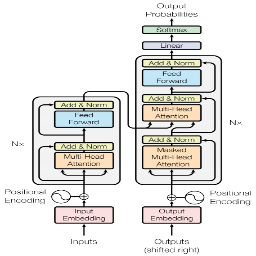

<IPython.core.display.Javascript object>

In [ ]:
array_to_img(image)

Image size: 256 X 256
Patch size: 42 X 42
Patches per image: 36
Elements per patch: 5292


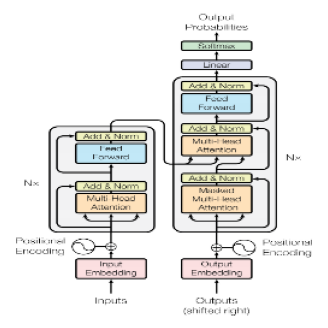

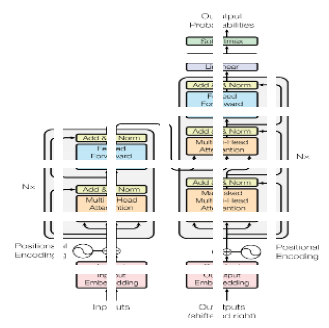

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.imshow(array_to_img(image))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

# Attention


1. BaseAttention(main)

    a. SelfAttention


    b. CrossAttention

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

<IPython.core.display.Javascript object>

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x, #[batch, seqlen, d_model]
        key=context, #[batch, patch_num, d_model]
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

<IPython.core.display.Javascript object>

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

<IPython.core.display.Javascript object>

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

<IPython.core.display.Javascript object>

In [ ]:
class FeedForword(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate = 0.1):
        super().__init__()

        
        self.seq = tf.keras.Sequential([
            Dense(dff, activation = 'relu'),
            Dense(d_model),
            Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()
        
    def call(self, x):
        x = self.add([x, self.seq(x)])
        return self.layernorm(x)

<IPython.core.display.Javascript object>

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        
        self.self_attention = GlobalSelfAttention(
            key_dim=d_model,
            num_heads=num_heads,
            dropout=dropout_rate
        )
        
        self.ffn = FeedForword(d_model=d_model, dff=dff,dropout_rate=dropout_rate)
        

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
        

<IPython.core.display.Javascript object>

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, patch_size, num_patches, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dff = dff
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.dropout_rate = dropout_rate
        
        
        self.patches = Patches(patch_size)
        # Encode patches.
        self.encoded_patches = PatchEncoder(num_patches, d_model)
        

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.patches(x)  # Shape `(batch_size, seq_len, d_model)`.
        x = self.encoded_patches(x)
        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dims = d_model, 
            dropout= dropout_rate
            )
        
        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dims = d_model, 
            dropout= dropout_rate
            )
        
        self.ffn = FeedForword(d_model=d_model, dff=dff,dropout_rate=dropout_rate)
               
        self.last_attn_scores = self.cross_attention.last_attn_scores

       
    def call(self, x, context):
        x = self.causal_attention(x)
        x = self.cross_attention(x=x, context = context)
        x = self.ffn(x)
        return x
        

<IPython.core.display.Javascript object>

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        
        self.num_layers = num_layers 
        self.d_model = d_model
        self.num_heads = num_heads 
        self.dff = dff
        self.vocab_size = vocab_size
        self.dropout_rate = dropout_rate=0.1
        
        self.positional_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.last_attn_scores = None


    def call(self, x, context):
        x = self.positional_embedding(x)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x=x, context=context)
            
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores


<IPython.core.display.Javascript object>

In [ ]:
class CaptionGenerator(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, patch_size, num_patches, dropout_rate=0.1):
        super().__init__()

        self.encoder = Encoder(
                            num_layers=num_layers,
                            d_model=d_model,
                            num_heads=num_heads,
                            dff=dff,
                            patch_size=patch_size,
                            num_patches=num_patches,
                            dropout_rate=dropout_rate,
                            )
        
        self.decoder = Decoder(
                            num_layers=num_layers,
                            d_model=d_model,
                            num_heads=num_heads,
                            dff=dff,
                            vocab_size=vocab_size,
                            dropout_rate=dropout_rate,
                            )
        
        self.final_layer = tf.keras.layers.Dense(vocab_size
                               
        )        
        self.decoder = Decoder(
                            num_heads=num_heads,
                            num_layers=num_layers,
                            d_model=d_model,
                            dff=dff,
                            vocab_size=vocab_size,
                            dropout_rate=dropout_rate,
                            )
        
        self.final_layer = tf.keras.layers.Dense(vocab_size)
        
    def call(self, inputs):  # sourcery skip: inline-immediately-returned-variable, use-contextlib-suppress
        x, context  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x=X, context=context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, max_len, target_vocab_size)

        # Return the final output and the attention weights.
        return logits

<IPython.core.display.Javascript object>